# Build Model

In [3]:
#!pip install gensim --upgrade
#!pip install keras --upgrade
#!pip install pandas --upgrade
#!pip install Keras-Preprocessing
#!pip install keras-tuner

In [1]:
import tensorflow as tf
print(tf.__version__)

C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


2.16.1


In [53]:
# DataFrame
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperModel, RandomSearch

import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
# Loading individual arrays
x_train = np.load('input/x_train.npy')
y_train = np.load('input/y_train.npy')
x_test = np.load('input/x_test.npy')
y_test = np.load('input/y_test.npy')

In [43]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [44]:
x_train 

array([[     0,      0,      0, ...,    712,    118,  24590],
       [     0,      0,      0, ...,    452,    378,  32447],
       [     0,      0,      0, ...,   2048,      4,   5487],
       ...,
       [     0,      0,      0, ...,    661,   4246, 290416],
       [     0,      0,      0, ...,     12,    477,    957],
       [     0,      0,      0, ...,      9,    502,    268]])

In [45]:
def check_and_fix_out_of_bounds(x_train, max_value):
    num_out_of_bounds = np.sum(x_train >= max_value)
    print(f"Number of out-of-bounds values: {num_out_of_bounds}")
    x_train[x_train >= max_value] = max_value - 1
    return x_train

x_train = check_and_fix_out_of_bounds(x_train, 5000)


Number of out-of-bounds values: 1421709


In [46]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperModel, RandomSearch

# Ensure all indices are within the valid range
x_train[x_train >= 5000] = 4999

# Define the HyperModel class
class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Embedding(input_dim=290418, output_dim=128, input_length=300))  # Adjust input_dim if necessary
        model.add(Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)))
        model.add(LSTM(hp.Int('lstm_units', min_value=50, max_value=200, step=50),
                       dropout=hp.Float('lstm_dropout', 0.1, 0.5, step=0.1),
                       recurrent_dropout=hp.Float('recurrent_dropout', 0.1, 0.5, step=0.1)))
        model.add(Dense(1, activation='sigmoid'))
        
        model.compile(
            optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        return model


# Initialize the tuner
tuner = RandomSearch(
    MyHyperModel(),
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='hyperparam_tuning'
)

# Print a summary of the search space
tuner.search_space_summary()

# Perform the hyperparameter search
tuner.search(x_train, y_train,
             epochs=10,
             validation_split=0.1,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the LSTM layer is {best_hps.get('lstm_units')} and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
The optimal dropout rate is {best_hps.get('dropout')} and the optimal LSTM dropout rate is {best_hps.get('lstm_dropout')}.
""")

# Build the model with the best hyperparameters and train it
model = MyHyperModel().build(best_hps)
history = model.fit(x_train, y_train,
                    epochs=10,
                    validation_split=0.1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])


Reloading Tuner from my_dir\hyperparam_tuning\tuner0.json
Search space summary
Default search space size: 5
dropout (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
lstm_units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
lstm_dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
recurrent_dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}

The hyperparameter search is complete. The optimal number of units in the LSTM layer is 100 and the optimal learning rate for the optimizer is 0.00010840583046861754.
The optimal dropout rate is 0.2 and the optimal LSTM dropout rate is 0.1.

Epoch 1/10
36

In [49]:
BATCH_SIZE = 1024

In [50]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 ━━━━━━━━━━━━━━━━━━━━ 265s 847ms/step - accuracy: 0.7811 - loss: 0.4558

ACCURACY: 0.7804968953132629
LOSS: 0.456944078207016
CPU times: total: 31.1 s
Wall time: 4min 25s


In [51]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


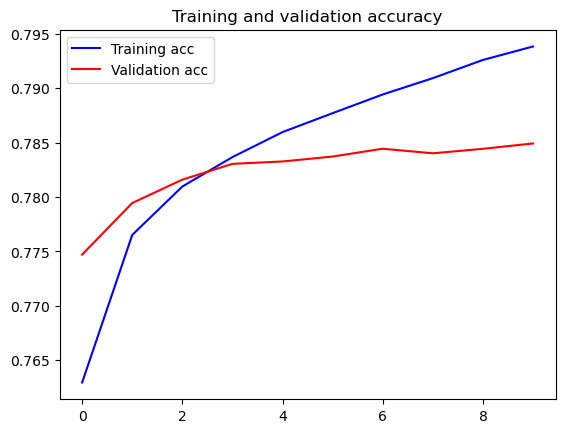

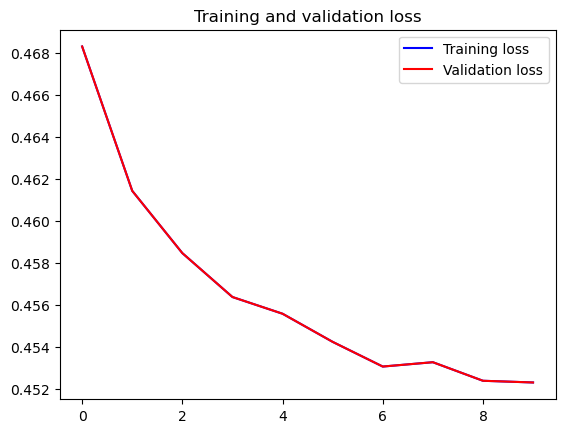

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['val_loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [57]:
# EXPORT
model_folder = 'model/randomsearch'
KERAS_MODEL = f"{model_folder}/model.keras"

In [58]:
model.save(KERAS_MODEL)

In [59]:
# Load
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model(KERAS_MODEL)

# Verify the model architecture and summary
loaded_model.summary()

C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (32, 300, 128)              │      37,173,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (32, 300, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (32, 100)                   │          91,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (32, 1)                     │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,530,412 (284.31 MB)

 Trainable params: 37,265,205 (142.16 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 37,265,207 (142.16 MB)

In [60]:
pred_probs = model.predict(x_test)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 350s 35ms/step


In [67]:
from sklearn.metrics import roc_curve, roc_auc_score
roc_auc = roc_auc_score(y_test, pred_probs)
print(f"ROC AUC Score: {roc_auc}")

ROC AUC Score: 0.8659608677600288


In [68]:
# Optionally, threshold the probabilities to get binary predictions
threshold = 0.5
loaded_pred_labels = (pred_probs >= threshold).astype(int)

# Print the predicted probabilities and binary predictions
print("Loaded Model Predicted Probabilities:", pred_probs[:10])
print("Loaded Model Predicted Labels:", loaded_pred_labels[:10])

Loaded Model Predicted Probabilities: [[0.38136056]
 [0.7512135 ]
 [0.6011098 ]
 [0.05822032]
 [0.53395987]
 [0.31193098]
 [0.7870922 ]
 [0.12913933]
 [0.01632102]
 [0.98345315]]
Loaded Model Predicted Labels: [[0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]]


ROC AUC Score: 0.8659608677600288


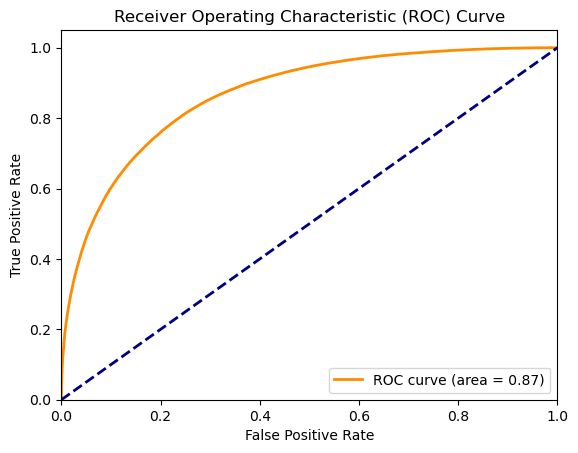

In [69]:
# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, pred_probs)
print(f"ROC AUC Score: {roc_auc}")

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, pred_probs)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

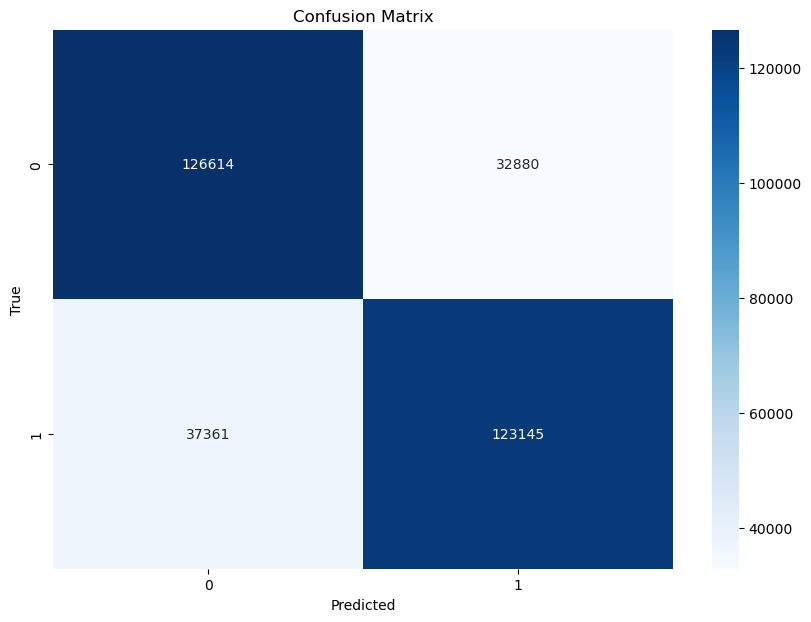

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
pred_labels = (pred_probs >= 0.5).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_test, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()